In [1]:
import sys
sys.path.append('..')
sys.path.append('/Users/jh7685/Documents/Projects/pysurfer')
from pysurfer.mgz_helper import map_values_as_mgz
from pysurfer.mgz_helper import load_mgzs, read_label
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
from timeit import default_timer as timer
import warnings
from itertools import product
from scipy import optimize
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
nsd_dir ='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset'
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
#freesurfer_dir='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer'

# Load beta values

In [3]:
subj='subj01'
hemi='lh'
betas = os.path.join(nsd_dir, 'nsddata_betas', 'ppdata', f'{subj}', 'nativesurface', 'nsdsyntheticbetas_fithrf_GLMdenoise_RR', f'{hemi}.betas_nsdsynthetic.hdf5')
design_mat=os.path.join(nsd_dir, 'nsddata', 'experiments', 'nsdsynthetic', 'nsdsynthetic_expdesign.mat')
task_keys=['fixation_task','memory_task']
stim_info=os.path.join(nsd_dir, 'nsdsyn_stim_description.csv')
task_average=True
eccentricity_path= os.path.join(nsd_dir, 'nsddata', 'freesurfer', f'{subj}', 'label',  f'{hemi}.prfeccentricity.mgz')

In [4]:
betas_df = sfm.get_whole_brain_betas(betas_path=betas, design_mat_path=design_mat,
                          stim_info_path=stim_info,
                          task_keys=task_keys, task_average=task_average, eccentricity_path=eccentricity_path,
                          x_axis='voxel', y_axis='stim_idx', long_format=True, reference_frame='relative')
betas_df = betas_df.query('~names.str.contains("intermediate").values')

# Test with V1 voxels

In [6]:
label_path=f'/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer/subj01/label/{hemi}.V1v.label'
V1_voxels = read_label(label_path, read_header=False, index_only=True)
V1_df = betas_df.query('voxel in @V1_voxels & 0.49 < eccentricity < 4.2')

In [7]:
# Define bins and labels for categorization
bins = [0.5, 1, 2, 4]  # Adjust bin edges as needed
labels = ['0.5-1', '1-2', '2-4']

# Use pd.cut to create a new column based on categorization
V1_df['eccentricity bin'] = pd.cut(V1_df['eccentricity'], bins=bins, labels=labels, right=False)
avg_V1_df = V1_df.groupby(['freq_lvl', 'eccentricity bin']).mean().reset_index()

In [12]:
random_voxels = utils.pick_random_voxels(avg_V1_df.voxel.unique(), n=3)
test = avg_V1_df.query('voxel in @random_voxels')
initial_params = np.random.random(3) + [0, 0.5, 0.5]

In [16]:
p_opt = pd.DataFrame({})
for v in random_voxels[:1]:
    v_tmp = test.query('voxel == @v')
    tmp_p_opt, _ = tuning.fit_logGaussian_curves(v_tmp, x='local_sf', y='betas',
                                                 initial_params=initial_params, goodness_of_fit=False)
    tmp_p_opt['voxel'] = v
    p_opt = pd.concat((tmp_p_opt, p_opt))
p_opt = p_opt.set_index('voxel').reset_index()

In [28]:
x='local_sf'
y='betas'
tmp = v_tmp.sort_values('local_sf')
y_pred = tuning.np_log_norm_pdf(tmp[x].to_list(), p_opt['amp'].values, p_opt['mode'].values, p_opt['sigma'].values)
# Compute residuals
residuals = tmp[y].to_list() - y_pred
# Calculate the total sum of squares (TSS)
ss_tot = np.sum((tmp[y] - np.mean(tmp[y])) ** 2)
# Calculate the residual sum of squares (RSS)
ss_res = np.sum(residuals ** 2)
# Calculate R^2
r_squared = 1 - (ss_res / ss_tot)
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals ** 2))


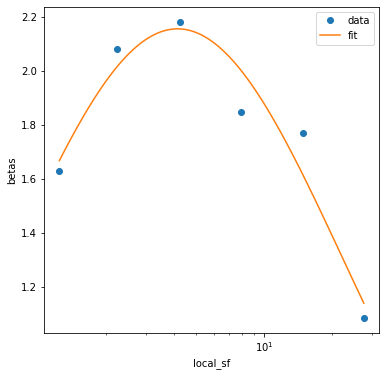

In [31]:
tuning.plot_logGaussian_fit(tmp, x, y, p_opt)

R^2: 0.9256804298642137
RMSE: 0.09733785614850642


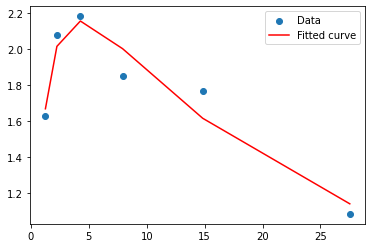

In [29]:

print(f'R^2: {r_squared}')
print(f'RMSE: {rmse}')

# Optionally, plot the data and the fit
plt.scatter(tmp[x].to_list(), tmp[y].to_list(), label='Data')
plt.plot(tmp[x].to_list(), y_pred, color='red', label='Fitted curve')
plt.legend()
plt.show()

# All voxels

In [29]:
avg_betas_df = betas_df.groupby(['voxel', 'freq_lvl']).mean().reset_index()
avg_betas_df = avg_betas_df[['voxel','freq_lvl','betas','local_sf']]

In [32]:
random_voxels = utils.pick_random_voxels(avg_betas_df.voxel.unique(), n=6)

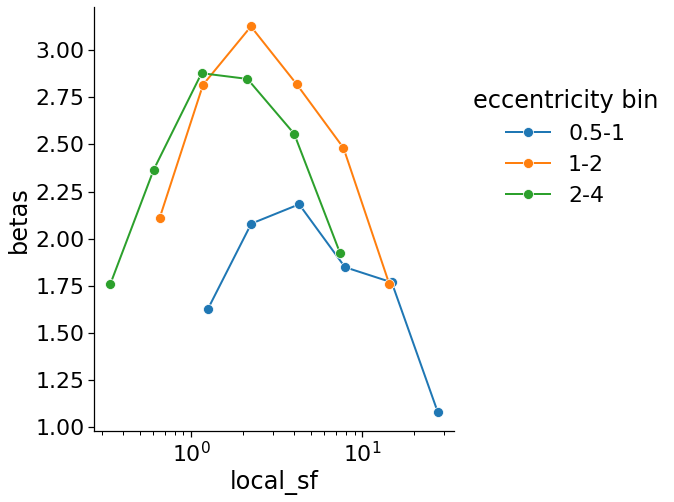

In [8]:
#save_path = os.path.join(output_dir, 'figures', 'tmp', 'random_voxel_datapoints.png')
vis1D.plot_curves_sns(avg_V1_df,
                      x='local_sf', y='betas', height=7,
                      hue='eccentricity bin',
                      to_logscale=True, save_path=None)

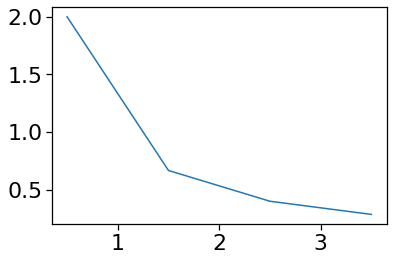

In [24]:
plt.plot(np.arange(0.5, 4), 1/np.arange(0.5, 4))

In [34]:
test = avg_betas_df.query('voxel in @random_voxels')
initial_params = np.random.random(3) + [0, 0.5, 0.5]

In [35]:
from timeit import default_timer as timer
p_opt = pd.DataFrame({})
for v in random_voxels:
    start = timer()
    v_tmp = test.query('voxel == @v')
    tmp, _ = tuning.fit_logGaussian_curves(v_tmp, x='local_sf', y='betas',
                                  initial_params=initial_params)
    print(f'Elapsed time: {np.round(timer() - start, 2)} sec')
    tmp['voxel'] = v
    p_opt = pd.concat((tmp, p_opt))
p_opt = p_opt.set_index('voxel').reset_index()

Elapsed time: 0.01 sec
Elapsed time: 0.01 sec
Elapsed time: 0.0 sec
Elapsed time: 0.0 sec
Elapsed time: 0.02 sec
Elapsed time: 0.01 sec


In [36]:
p_opt

,voxel,amp,mode,sigma
0,77042,1.181493,3.424390,0.257080
1,131382,5.115585,0.031250,3.061119
2,221861,0.400305,0.603484,0.427444
3,115610,0.322129,0.485880,0.333985
4,186892,0.922396,4.346354,0.206840
5,166589,0.088278,40.038533,2.483184


In [93]:
model_df = pd.DataFrame({})
for v in random_voxels:
    tmp = test.query('voxel == @v')
    my_model = tuning.LogGaussianTuningModel()
    my_dataset = tuning.LogGaussianTuningDataset(tmp['local_sf'], tmp['betas'])
    _, _ = tuning.fit_tuning_curves(my_model, my_dataset,
                                                       learning_rate=0.001,
                                                       max_epoch=7000,
                                                       print_every=7000,
                                                       save_path=None)
    tmp_model_df = tuning.model_to_df(my_model)
    tmp_model_df['voxel'] = v
    model_df = pd.concat((model_df, tmp_model_df))

model_df = model_df.set_index('voxel').reset_index().sort_values('voxel')
model_df

**epoch no.0 loss: 0.18873
**epoch no.6999 loss: 0.13536
**epoch no.7000: Finished! final params {'amp': -0.009, 'mode': 0.99, 'sigma': 1.171}
Elapsed time: 2.8 sec 

**epoch no.0 loss: 2.08241
**epoch no.6999 loss: 0.02897
**epoch no.7000: Finished! final params {'amp': 1.731, 'mode': 1.033, 'sigma': 3.899}
Elapsed time: 2.72 sec 

**epoch no.0 loss: 0.17124
**epoch no.6999 loss: 0.03817
**epoch no.7000: Finished! final params {'amp': 0.611, 'mode': 0.187, 'sigma': 4.614}
Elapsed time: 2.59 sec 

**epoch no.0 loss: 0.01764
**epoch no.6999 loss: 0.00477
**epoch no.7000: Finished! final params {'amp': 0.126, 'mode': 5.426, 'sigma': 6.6}
Elapsed time: 2.59 sec 

**epoch no.0 loss: 0.11362
**epoch no.6999 loss: 0.03488
**epoch no.7000: Finished! final params {'amp': 0.318, 'mode': 5.955, 'sigma': 5.003}
Elapsed time: 2.61 sec 

**epoch no.0 loss: 11.80432
**epoch no.6999 loss: 0.05506
**epoch no.7000: Finished! final params {'amp': 3.87, 'mode': 1.279, 'sigma': 3.493}
Elapsed time: 2.59 s

,voxel,amp,mode,sigma
5,5125,3.870340,1.278724,3.492942
1,24909,1.730689,1.033178,3.899222
3,48214,0.125640,5.425802,6.600410
4,108870,0.318414,5.954783,5.002711
2,135717,0.610583,0.186667,4.614312
0,146938,-0.008949,0.989983,1.171298


In [94]:
p_opt['method'] = 'curvefit'
model_df['method'] = 'pytorch'
all_df = pd.concat((p_opt, model_df))
all_df = pd.melt(all_df, id_vars=['voxel','method'], value_vars=['amp','mode','sigma'], var_name='params', value_name='value')

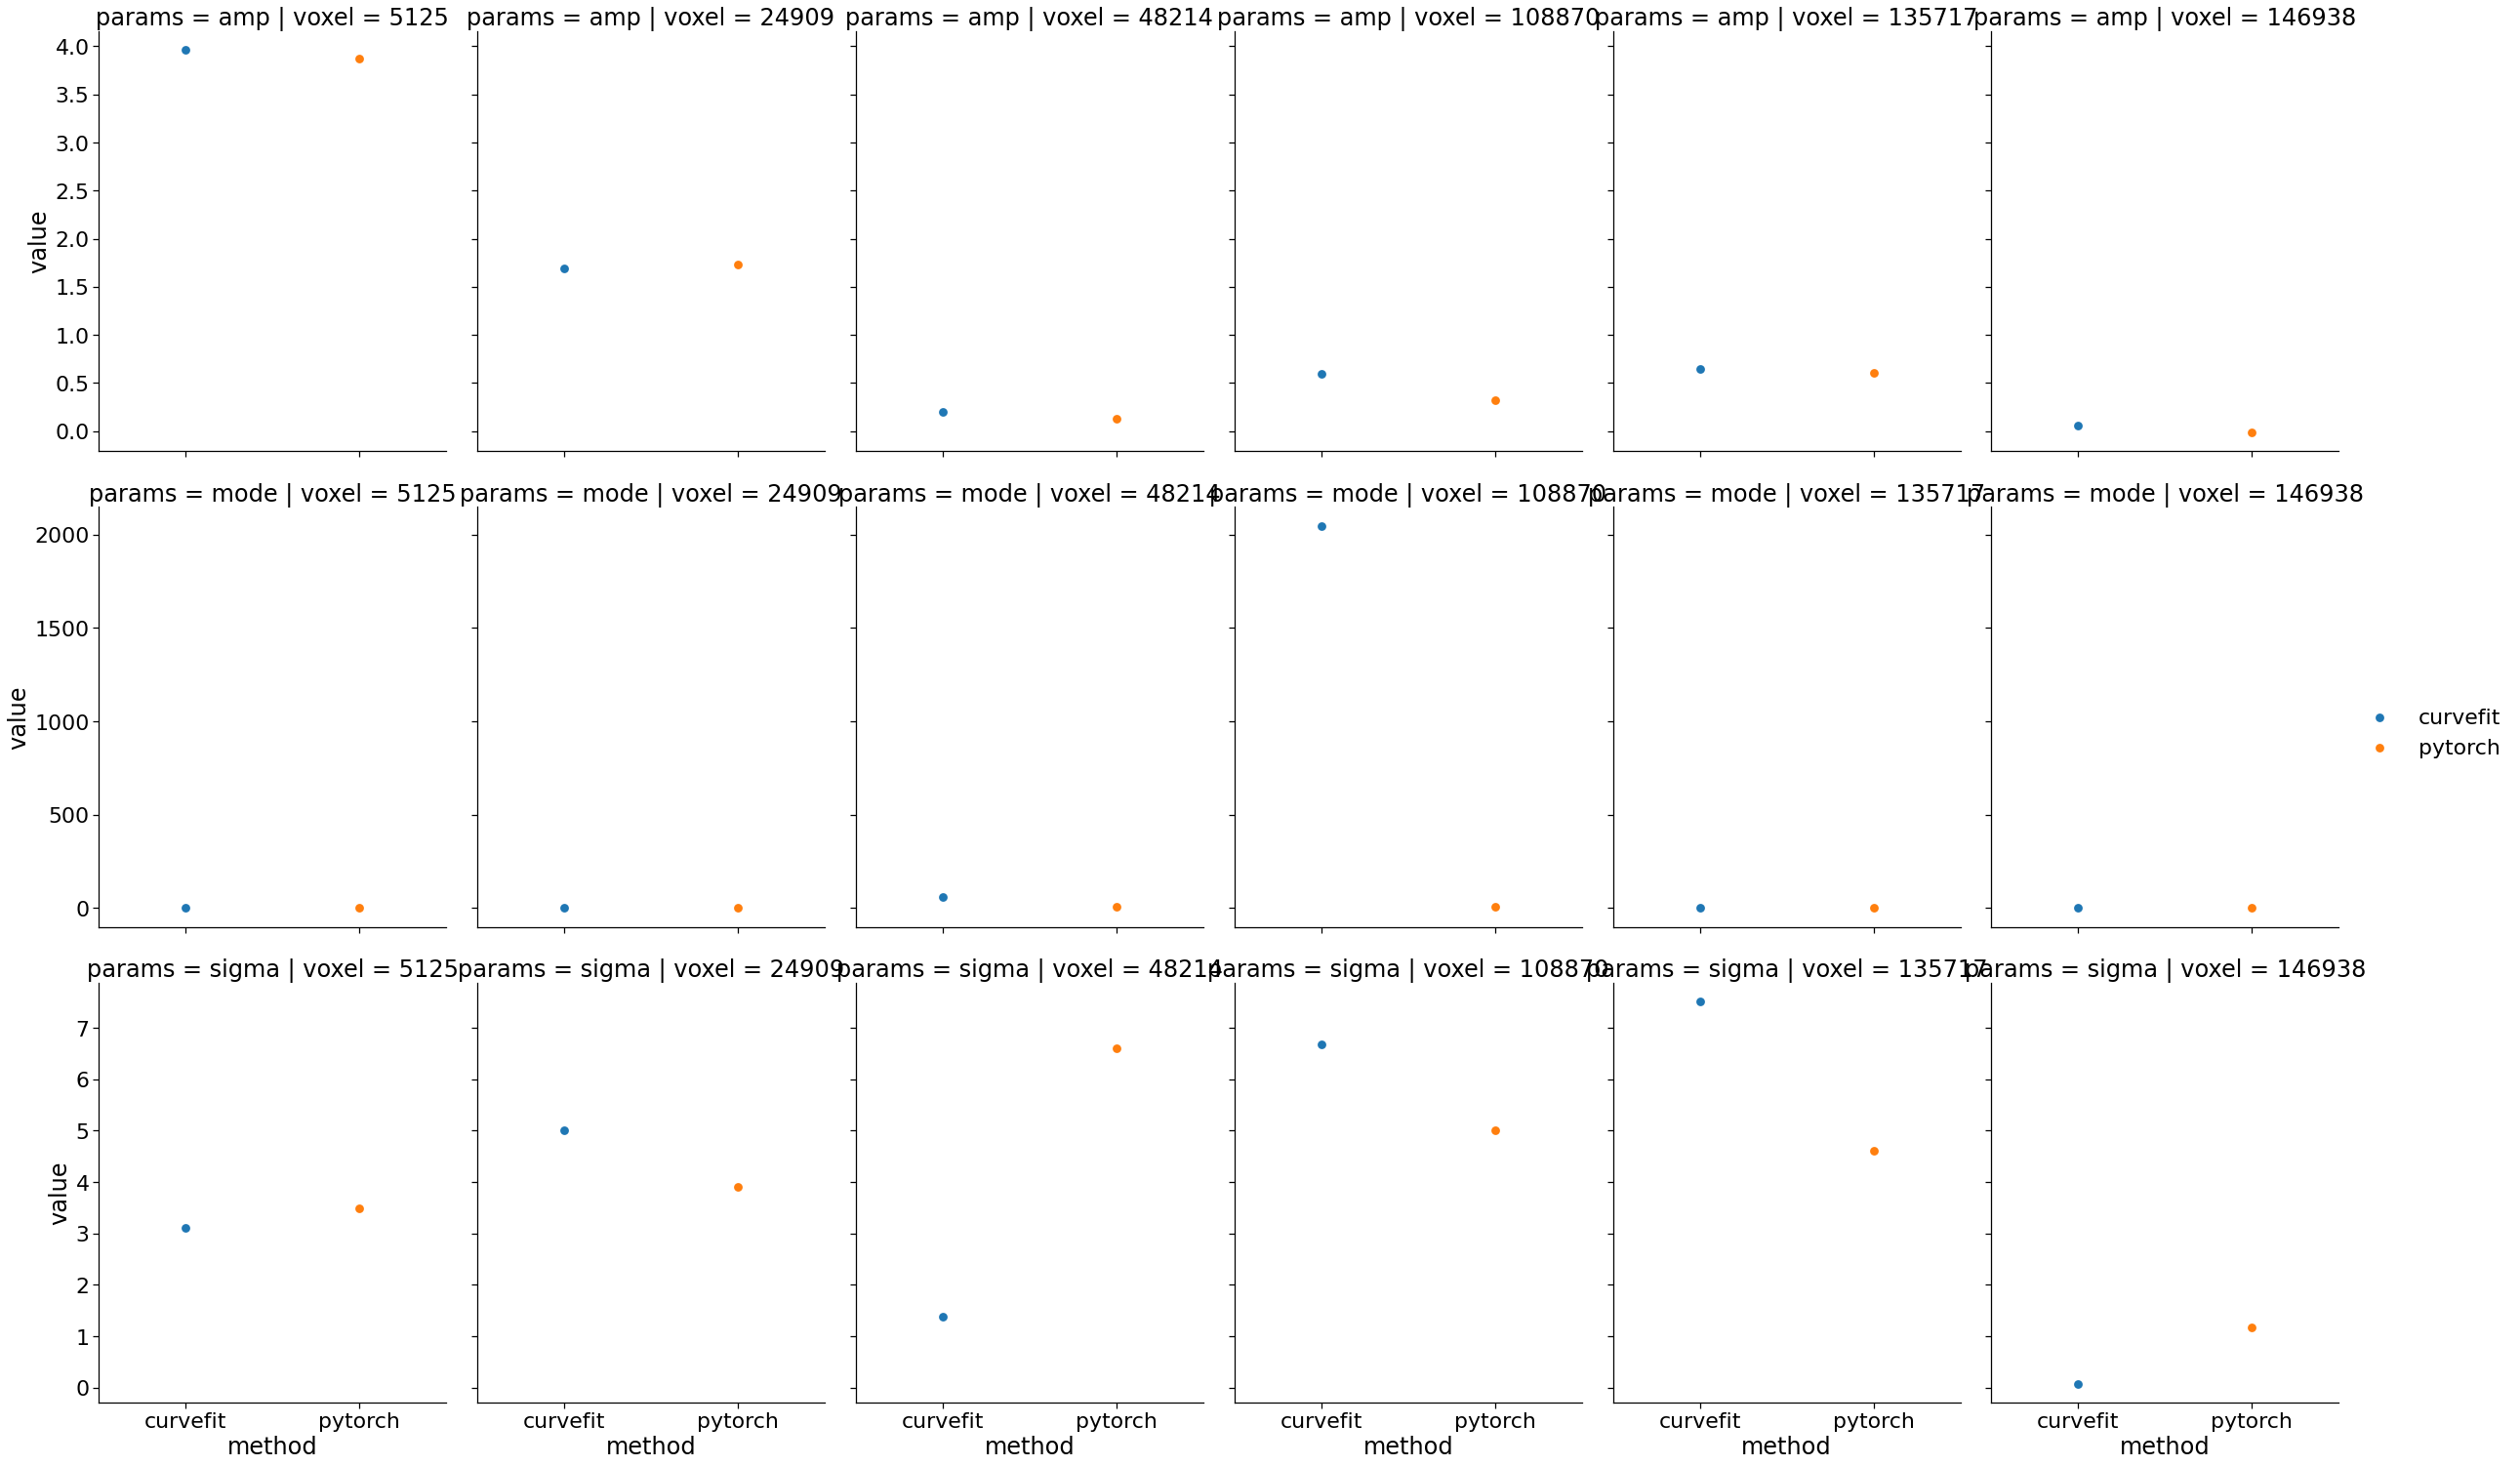

In [119]:
sns.set_context('notebook', font_scale=2)
g = sns.catplot(kind='point', data=all_df, height=7,
                col='voxel', hue='method', x='method', y='value',
                row='params', sharey='row', aspect=0.8)
g.add_legend()
save_path = os.path.join(output_dir, 'figures', 'tmp', 'random_voxel_params_comparison.png')
utils.save_fig(save_path)

In [150]:
diff_df = p_opt[['voxel','amp','mode','sigma']].set_index('voxel').subtract(model_df[['voxel','amp','mode','sigma']].set_index('voxel'), fill_value=0).reset_index()
diff_df = pd.melt(diff_df, id_vars='voxel', var_name='params')
diff_df = diff_df.query('not ((voxel == 108870) & (params == "mode"))')

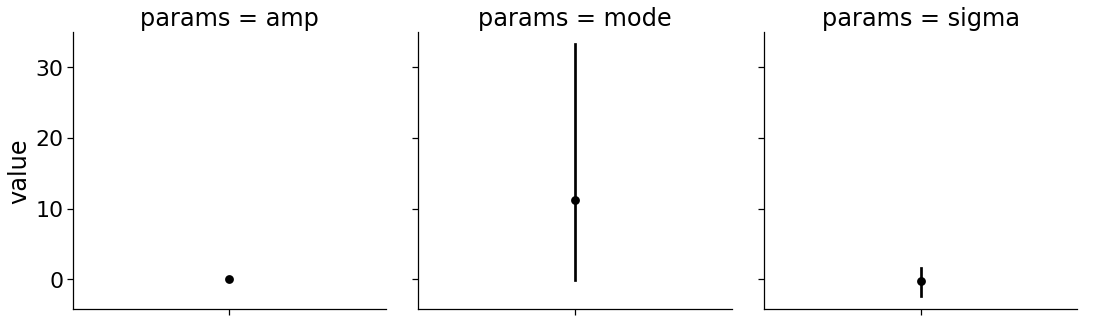

In [156]:
sns.set_context('notebook', font_scale=2)
g = sns.catplot(kind='point', data=diff_df, col='params', sharey=True,
                 y='value', color='k')
g.add_legend()
save_path = os.path.join(output_dir, 'figures', 'tmp', 'random_voxel_params_comparison_diff.png')
utils.save_fig(save_path)

In [ ]:
vis1D.plot_sf_curves(avg_betas_df.query('voxel in @random_voxels'), params_df=p_opt,
                     x='local_sf', y='betas', col='voxel', hue='voxel')



In [127]:
tmp = pd.merge(p_opt[['voxel','amp','mode','sigma']], model_df[['voxel','amp','mode','sigma']], on='voxel')
for p in ['amp', 'mode', 'sigma']:
    new_tmp[f'{p}_x'] - tmp[f'{p}_y']


,voxel,amp_x,mode_x,sigma_x,amp_y,mode_y,sigma_y
0,5125,3.960797,1.202405,3.104096,3.870340,1.278724,3.492942
1,108870,0.601012,2047.749636,6.673347,0.318414,5.954783,5.002711
2,48214,0.198487,60.444568,1.374332,0.125640,5.425802,6.600410
3,135717,0.649120,0.031250,7.509778,0.610583,0.186667,4.614312
4,24909,1.692397,1.290753,5.009651,1.730689,1.033178,3.899222
5,146938,0.054963,2.301032,0.075649,-0.008949,0.989983,1.171298


# Plot loss history to see convergence

In [78]:
hemi='rh'
subj_list = [utils.sub_number_to_string(sn, dataset='nsdsyn') for sn in np.arange(1,9)]
f = [f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_anova/voxel-tuning/train_history/nsdsyn/loss-history_voxel-test100_hemi-{hemi}_sub-{subj}.hdf' for subj in subj_list]
args = ['sub', 'hemi']
loss_history_df = utils.load_history_files(f, *args)

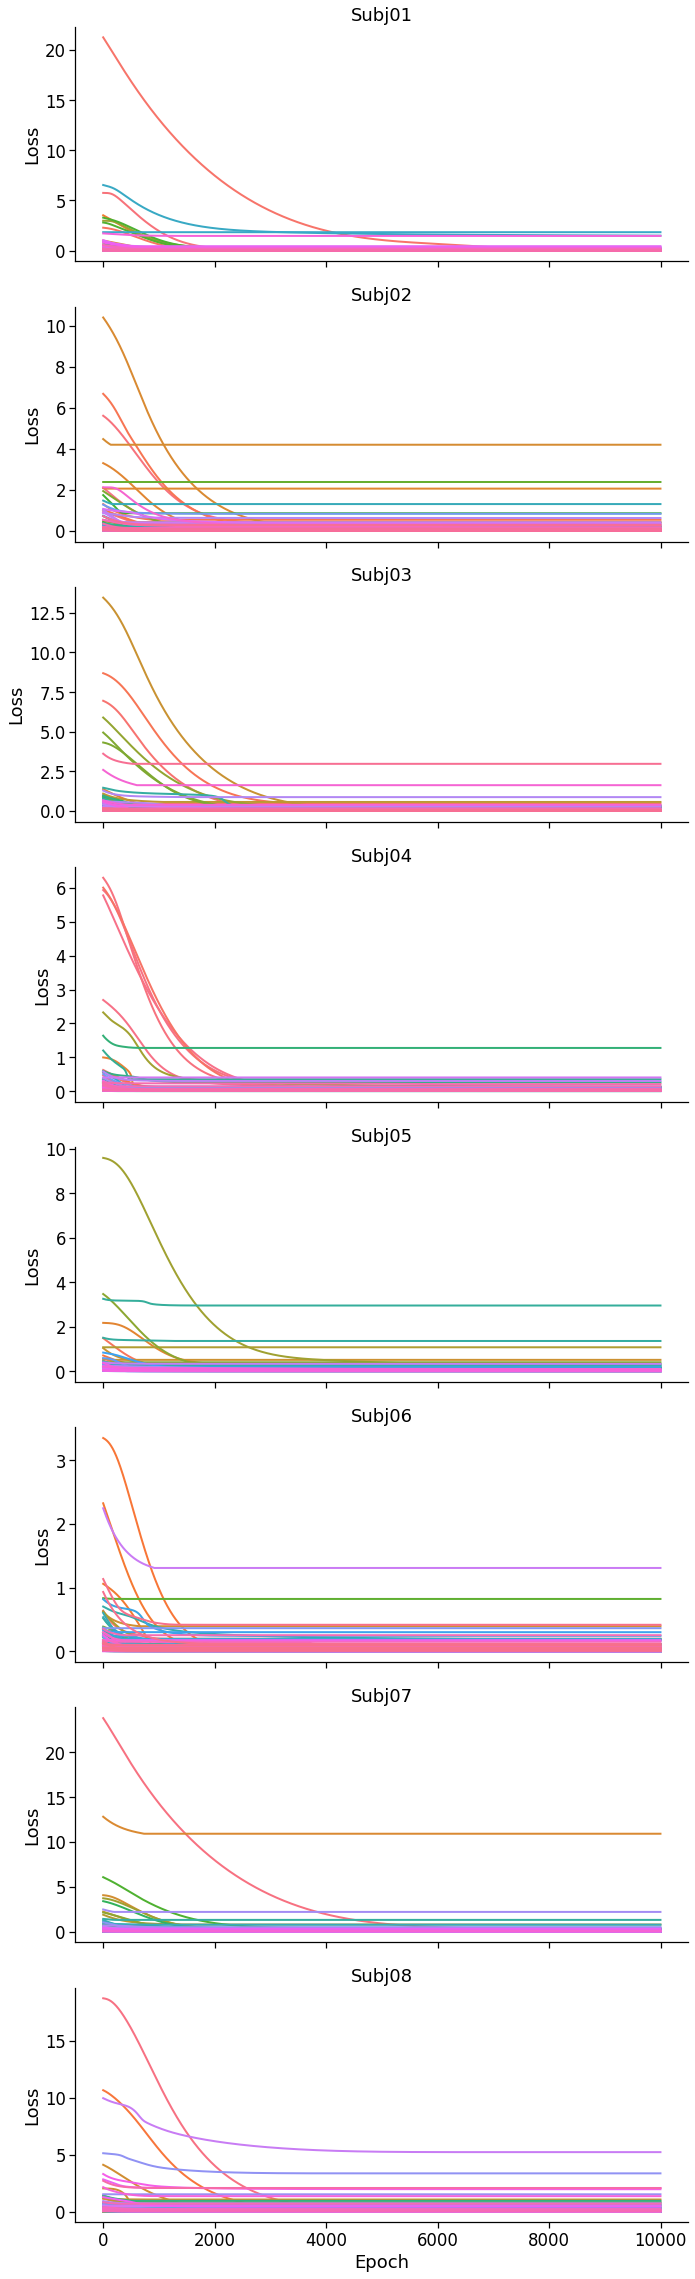

In [84]:
vis.plot_loss_history(loss_history_df,
                      hue='voxel',
                      col='sub', log_y=False, sharey=False, ci=None,
                      )

In [4]:
f_path='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer/subj01/label/rh.prfeccentricity.mgz'
template = load_mgzs(f_path, fdata_only=True, squeeze=False)
w=pd.read_hdf('/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/voxel-tuning/nsdsyn/method-curvefit_hemi-rh_sub-subj01.hdf')
w =w.sort_values('voxel').set_index('voxel').reset_index()
w

,voxel,amp,mode,sigma,sub
0,0,1.413152,2.353942,4.438557,subj01
1,1,1.709874,0.755579,3.594061,subj01
2,2,1.676826,0.854544,2.910843,subj01
3,3,1.658245,0.853900,2.575728,subj01
4,4,1.760927,1.228032,2.329814,subj01
...,...,...,...,...,...
226596,226596,0.717792,0.415054,0.219247,subj01
226597,226597,2.811566,1.221270,0.238975,subj01
226598,226598,0.242590,2.278509,6.708375,subj01
226599,226599,0.393078,3.994524,10.000000,subj01


In [5]:
map_values_as_mgz(f_path, w['amp'].to_numpy(), save_path='/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj01_method-curvefit_value-amp.mgz')
map_values_as_mgz(f_path, w['mode'].to_numpy(), save_path='/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj01_method-curvefit_value-mode.mgz')
map_values_as_mgz(f_path, w['sigma'].to_numpy(), save_path='/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/rh.sub-subj01_method-curvefit_value-sigma.mgz')

In [79]:
from scipy.stats import gmean

all_subj_mgz = []
for hemi in hemi_list:
    output_path = f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.fsaverage_sub-average_value-precision.mgz'
    for subj in subj_list:
        f_path =f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.fsaverage_sub-{subj}_value-precision.mgz'
        mgz = load_mgzs(f_path, fdata_only=False, squeeze=False)
        all_subj_mgz.append(mgz.get_fdata())
    avg_mgz = np.mean(all_subj_mgz, axis=0)
    map_values_as_mgz(f_path, avg_mgz, save_path=output_path)

In [207]:
all_subj_mgz = []
for hemi in hemi_list:
    output_path = f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.masked-individual_fsaverage_sub-average_method-curvefit_value-mode.mgz'
    for subj in subj_list:
        f_path =f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.masked-individual_fsaverage_sub-average_method-curvefit_value-mode.mgz'
        mgz = load_mgzs(f_path, fdata_only=False, squeeze=False)
        all_subj_mgz.append(mgz.get_fdata())
    avg_mgz = np.mean(all_subj_mgz, axis=0)
    map_values_as_mgz(f_path, avg_mgz, save_path=output_path)

In [93]:
for hemi in hemi_list:
    f_path = f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.bin_fsaverage_sub-average_value-precision.mgz'
    mgz = load_mgzs(f_path, fdata_only=True, squeeze=False)
    data_mgz = load_mgzs(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.fsaverage_sub-average_method-curvefit_value-mode.mgz', fdata_only=False, squeeze=False)
    f_data = data_mgz.get_fdata()
    new_data = mgz*f_data
    output_path = f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.masked_fsaverage_sub-average_method-curvefit_value-mode.mgz'
    map_values_as_mgz(f_path, new_data, save_path=output_path)

In [104]:
all_array = []
for subj, hemi in product(subj_list, hemi_list):
    precision = load_mgzs(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.fsaverage_sub-{subj}_value-precision.mgz', fdata_only=True, squeeze=True)
    prec
    tmp = load_mgzs(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.fsaverage_sub-{subj}_method-curvefit_value-mode.mgz', fdata_only=True, squeeze=True)
    #tmp = tmp[tmp != 0]
    #all_array.append(tmp)

ValueError: too many values to unpack (expected 2)

In [118]:
all_array = []

for subj, hemi in product(subj_list, hemi_list):
    precision = load_mgzs(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.fsaverage_sub-{subj}_value-precision.mgz', fdata_only=True, squeeze=True)
    tmp = load_mgzs(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.fsaverage_sub-{subj}_method-curvefit_value-mode.mgz', fdata_only=True, squeeze=True)
    mask = precision > 11
    tmp[mask] = 0
    output_path = f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.masked-individual_fsaverage_sub-average_method-curvefit_value-mode.mgz'
    map_values_as_mgz(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.fsaverage_sub-{subj}_value-precision.mgz', tmp, save_path=output_path)

In [163]:
from pysurfer.mgz_helper import load_labels_and_data, get_vertices_in_label, read_label
test = {}
label_dir=f'/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer/fsaverage/label'
labels_raw = ['V1v', 'V1d', 'V2v','V2d', 'V3v','V3d', 'hV4', 'FFA-1', 'FFA-2', 'PPA']
labels = [f'bin-min-0.5_probmap_{roi}_smooth.label' for roi in labels_raw]
label_path_list = [f'{label_dir}/{hemi}.{l}' for l in labels]
for l, l_path in zip(labels_raw, label_path_list):
    tmp = []
    for subj, hemi in product(subj_list, hemi_list):

        mgz_path = f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.masked-individual_fsaverage_sub-average_method-curvefit_value-mode.mgz'

        w = read_label(l_path, read_header=False, index_only=True)
        dat = load_mgzs(mgz_path, fdata_only=True, squeeze=True)
        tmp.append(dat[w])
    test[l] = tmp

In [209]:
from pysurfer.mgz_helper import load_labels_and_data, get_vertices_in_label, read_label
test = {}
label_dir=f'/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer/fsaverage/label'
labels_raw = ['V1v', 'V1d', 'V2v','V2d', 'V3v','V3d', 'hV4', 'FFA-1', 'FFA-2', 'PPA']
labels = [f'bin-min-0.5_probmap_{roi}_smooth.label' for roi in labels_raw]
label_path_list = [f'{label_dir}/{hemi}.{l}' for l in labels]
for l, l_path in zip(labels_raw, label_path_list):
    tmp = []

    mgz_path = f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/{hemi}.masked_fsaverage_sub-average_method-curvefit_value-mode.mgz'
    w = read_label(l_path, read_header=False, index_only=True)
    dat = load_mgzs(mgz_path, fdata_only=True, squeeze=True)
    tmp.append(dat[w])
    test[l] = tmp

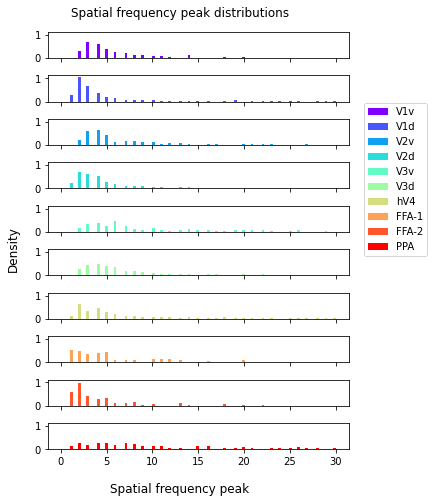

In [213]:
fig, axes = plt.subplots(len(labels_raw), 1,figsize=(5,7), sharey=True, sharex=True)
fig.suptitle('Spatial frequency peak distributions')
colors = plt.cm.rainbow(np.linspace(0, 1, len(labels_raw)))
#bins = [0.1, 1, 10, 100]
for i, l in enumerate(labels_raw):
    a = test[l]
    #a = a[a != 0]
    axes[i].hist(a, bins=100, range=(0.1, 30), label=l, density=True, color=colors[i])
    #plt.xscale('log')
fig.supxlabel('Spatial frequency peak')
fig.supylabel('Density')
fig.legend(bbox_to_anchor=(1.2,0.8))
plt.tight_layout()
plt.savefig('/Volumes/server/Projects/sfp_nsd/derivatives/figures/distributions2.png', bbox_inches='tight')

In [176]:
bins = 10**(np.arange(0,2))
print(bins)

[ 1 10]
